# Sine Walk Analysis with GPS Data

## How to Run the Code
1. Ensure all required packages are installed:
   ```bash
   pip install -r requirements.txt
   ```

2. The code uses the following custom functions from [final.py](SchrodingersStruggle/python/final.py):
   - `fahrenheit_to_kelvin()`: Converts temperature from F to K
   - `parse_temperature_from_markdown()`: Extracts temperature from experiment metadata
   - `list_markdown_files()`: Lists markdown files containing experiment data
   - `fit_nonlinear()`: Performs nonlinear fitting for sine waves
   - `fft_wrapper()` and `ifft_wrapper()`: Handles Fourier transforms
   - `rotate_to_horizontal()`: Rotates coordinates to align with the horizontal axis

3. Data files must be organized as follows:
   - GPS data in CSV format with columns for Latitude and Longitude.
   - Markdown files with temperature readings.

4. To generate the plots:
   - Run the cells in the Jupyter Notebook sequentially.
   - The first set of plots will show the adjusted walking paths with sine fits.
   - The second set of plots will display the FFT results of each walk.
   - The final plot will show the inverse FFT of the mean frequency components.

## Bibliography

1. FFT Implementation and Analysis:
   - NumPy FFT Documentation: https://numpy.org/doc/stable/reference/routines.fft.html
   - Nyquist frequency: https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

2. Nonlinear Fitting:
   - Non-linear least square fitting: https://en.wikipedia.org/wiki/Non-linear_least_squares

3. Data Collection:
   - Phyphox app: https://phyphox.org

4. Temperature Conversion:
   - NIST Temperature Conversion: https://www.nist.gov/pml/weights-and-measures/si-units-temperature



As a brief note, I know we are only supposed to generate one plot for each of the tasks given, but since I found them quite cool, I plotted 3 side by side for comparison for each figure plotted. I will also plot the single figure as supplement.

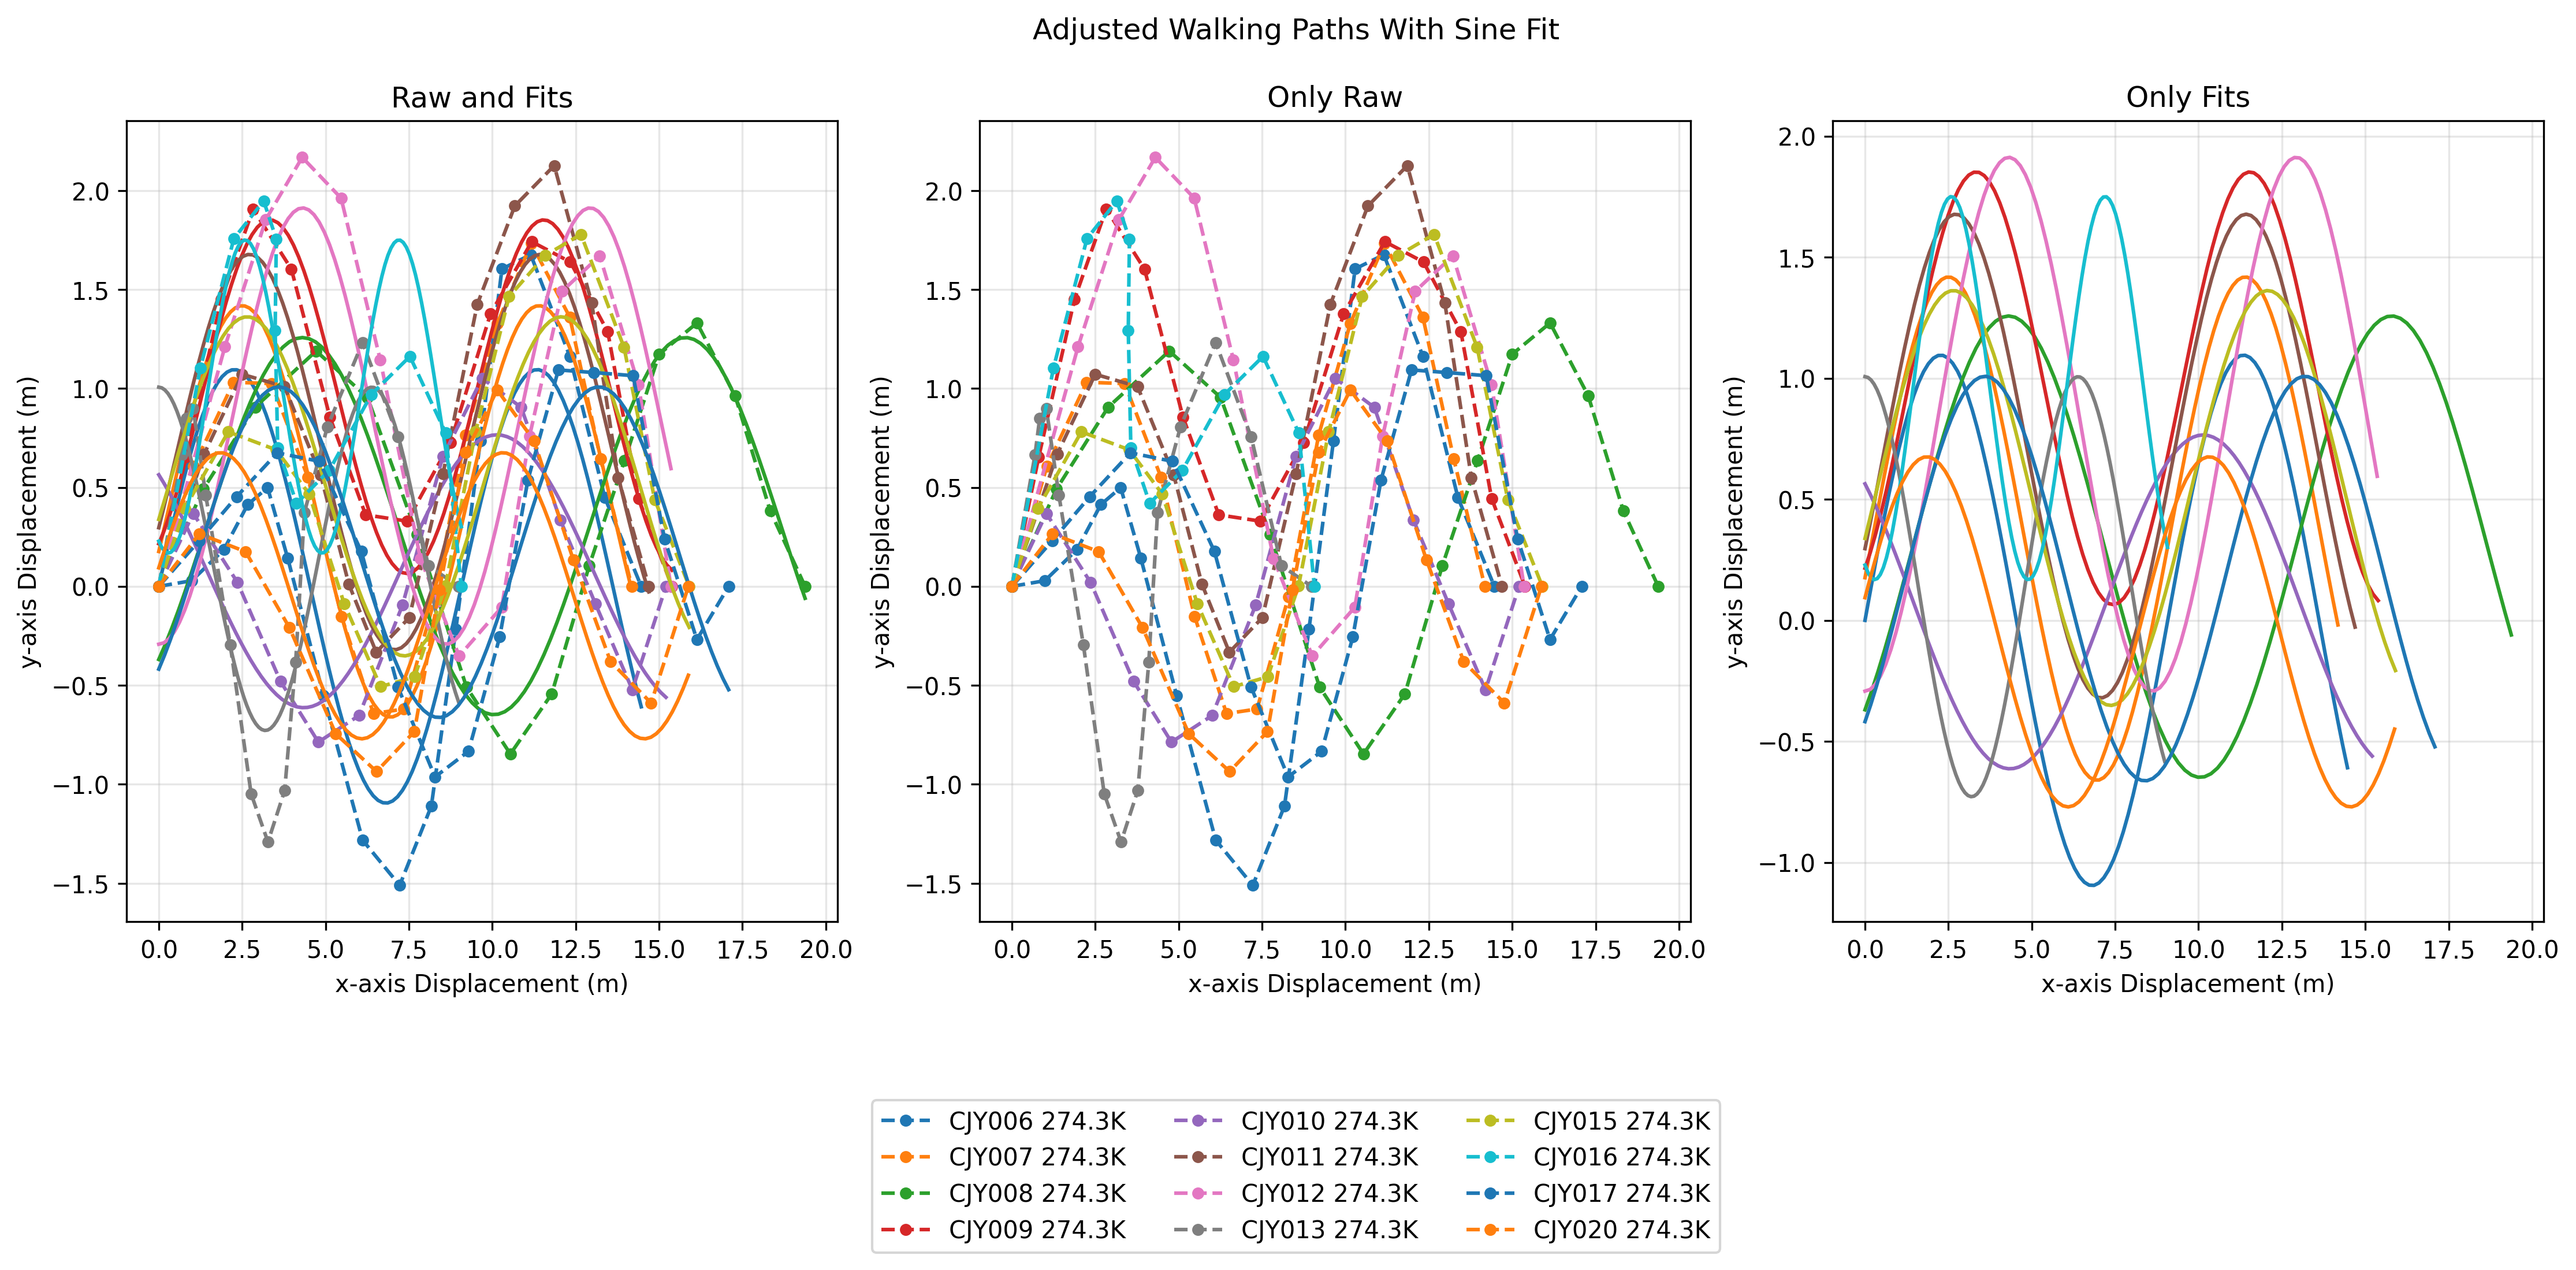

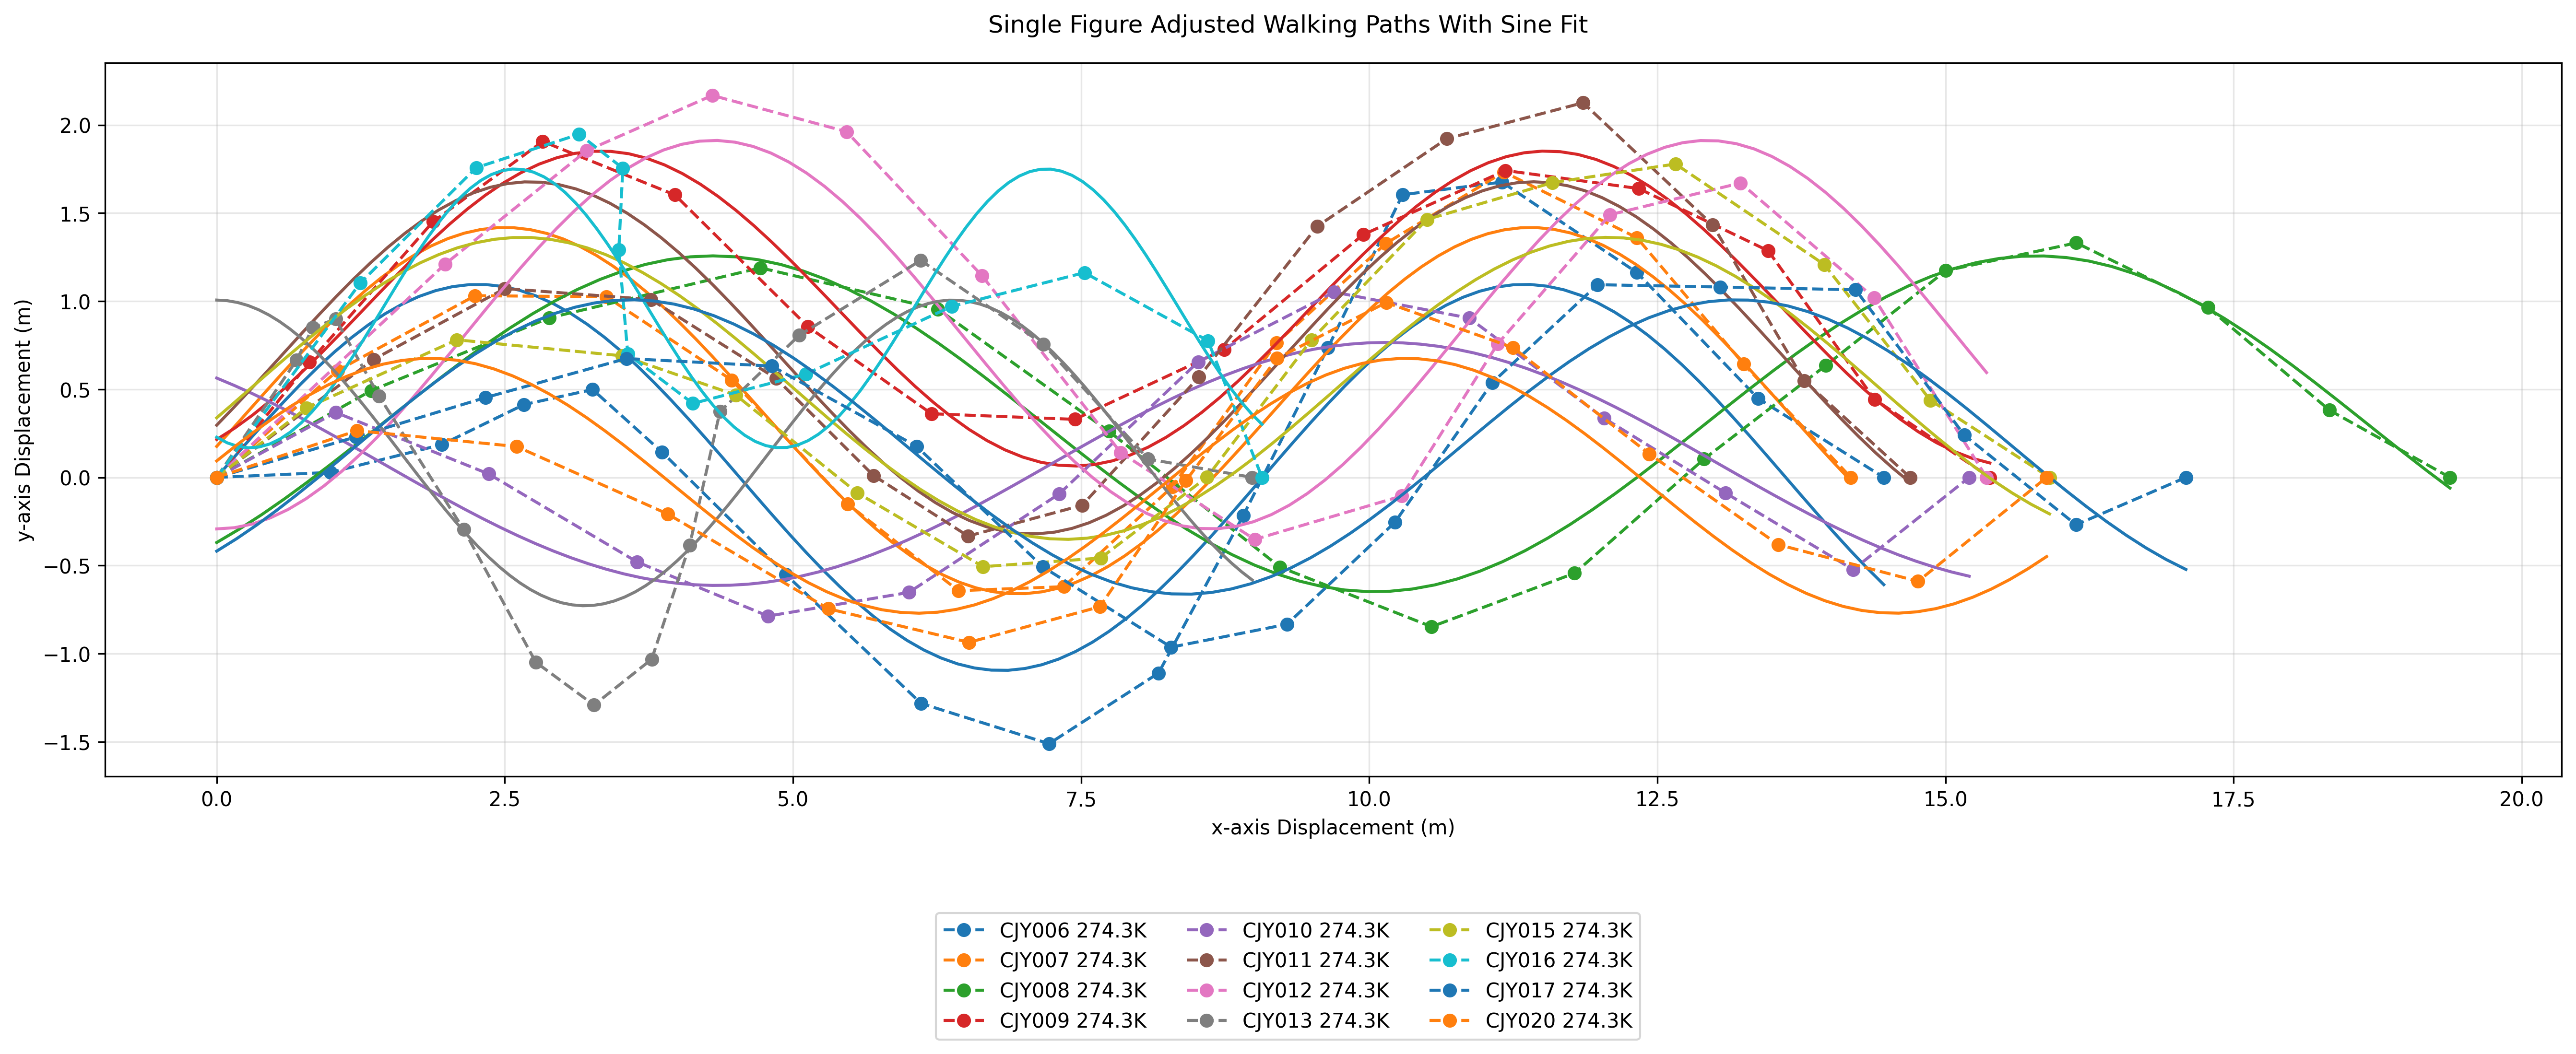

In [71]:
# Only doing this since the two functions are in different directories.
import sys
sys.path.append('/workspaces/CP1-24-final/SchrodingersStruggle/python')  # Add python directory to path

import final as f
import gps_location as gps
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get all sinewalk markdown files
md_files = f.list_markdown_files('/workspaces/CP1-24-final/SchrodingersStruggle/data/final', 'sinewalk')

# Set up figures
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), dpi=300, squeeze=True)
single_fig, single_ax = plt.subplots(1, 1, figsize=(18, 6), dpi=300, squeeze=True)
# Process each walk
for md_file in md_files:
    unique_id = md_file.split('/')[-1].split('_')[0]
    #! NOTE: Skip the following walks, as their data was completely messed up.
    # It may be because it was cloudy, so the gps glitched out sometimes.
    if unique_id in ['CJY001','CJY002','CJY003','CJY004','CJY005','CJY014','CJY018','CJY019']:
        continue
    temp_f = f.parse_temperature_from_markdown(md_file)
    temp_k = f.fahrenheit_to_kelvin(temp_f)
    
    # Get corresponding CSV file
    csv_file = md_file.replace('.md', '.csv')
    data = pd.read_csv(csv_file)
    
    # Convert GPS coordinates to meters using gps_location function from midterm
    # Skip first and last points as they have very large variation.
    longitudes = data['Longitude (°)'].values[3:-3].tolist()  # Convert to list
    latitudes = data['Latitude (°)'].values[3:-3].tolist()    # Convert to list
    x, y = gps.convert_xy(longitudes, latitudes)
    x, y = f.rotate_to_horizontal(x,y)
    # Plot data points
    line = ax1.plot(x, y, 'o--', markersize=4, label=f'{unique_id} {temp_k:.1f}K')
    color = line[0].get_color()
    ax2.plot(x, y, 'o--', markersize=4, color = color)
    single_ax.plot(x, y, 'o--', color = color, label=f'{unique_id} {temp_k:.1f}K')
    
    # Fit sine wave
    fitted_params = f.fit_nonlinear(x, y,n=5)

    # Plot fitted curve
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = fitted_params['amplitude'] * np.sin(2*np.pi*fitted_params['frequency']*x_fit + fitted_params['phi']) + fitted_params['constant']
    ax1.plot(x_fit, y_fit, '-', color = color)
    ax3.plot(x_fit, y_fit, '-', color = color)
    single_ax.plot(x_fit, y_fit, '-', color = color)

# Plot 3 subfigures.
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('x-axis Displacement (m)')
    ax.set_ylabel('y-axis Displacement (m)')
    ax.grid(True, alpha=0.3)

fig.suptitle('Adjusted Walking Paths With Sine Fit')
ax1.set_title('Raw and Fits')
ax2.set_title('Only Raw')
ax3.set_title('Only Fits')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

# Plot single figure
single_ax.set_xlabel('x-axis Displacement (m)')
single_ax.set_ylabel('y-axis Displacement (m)')
single_ax.grid(True, alpha=0.3)
single_fig.suptitle('Single Figure Adjusted Walking Paths With Sine Fit')
single_fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.tight_layout()
plt.show()

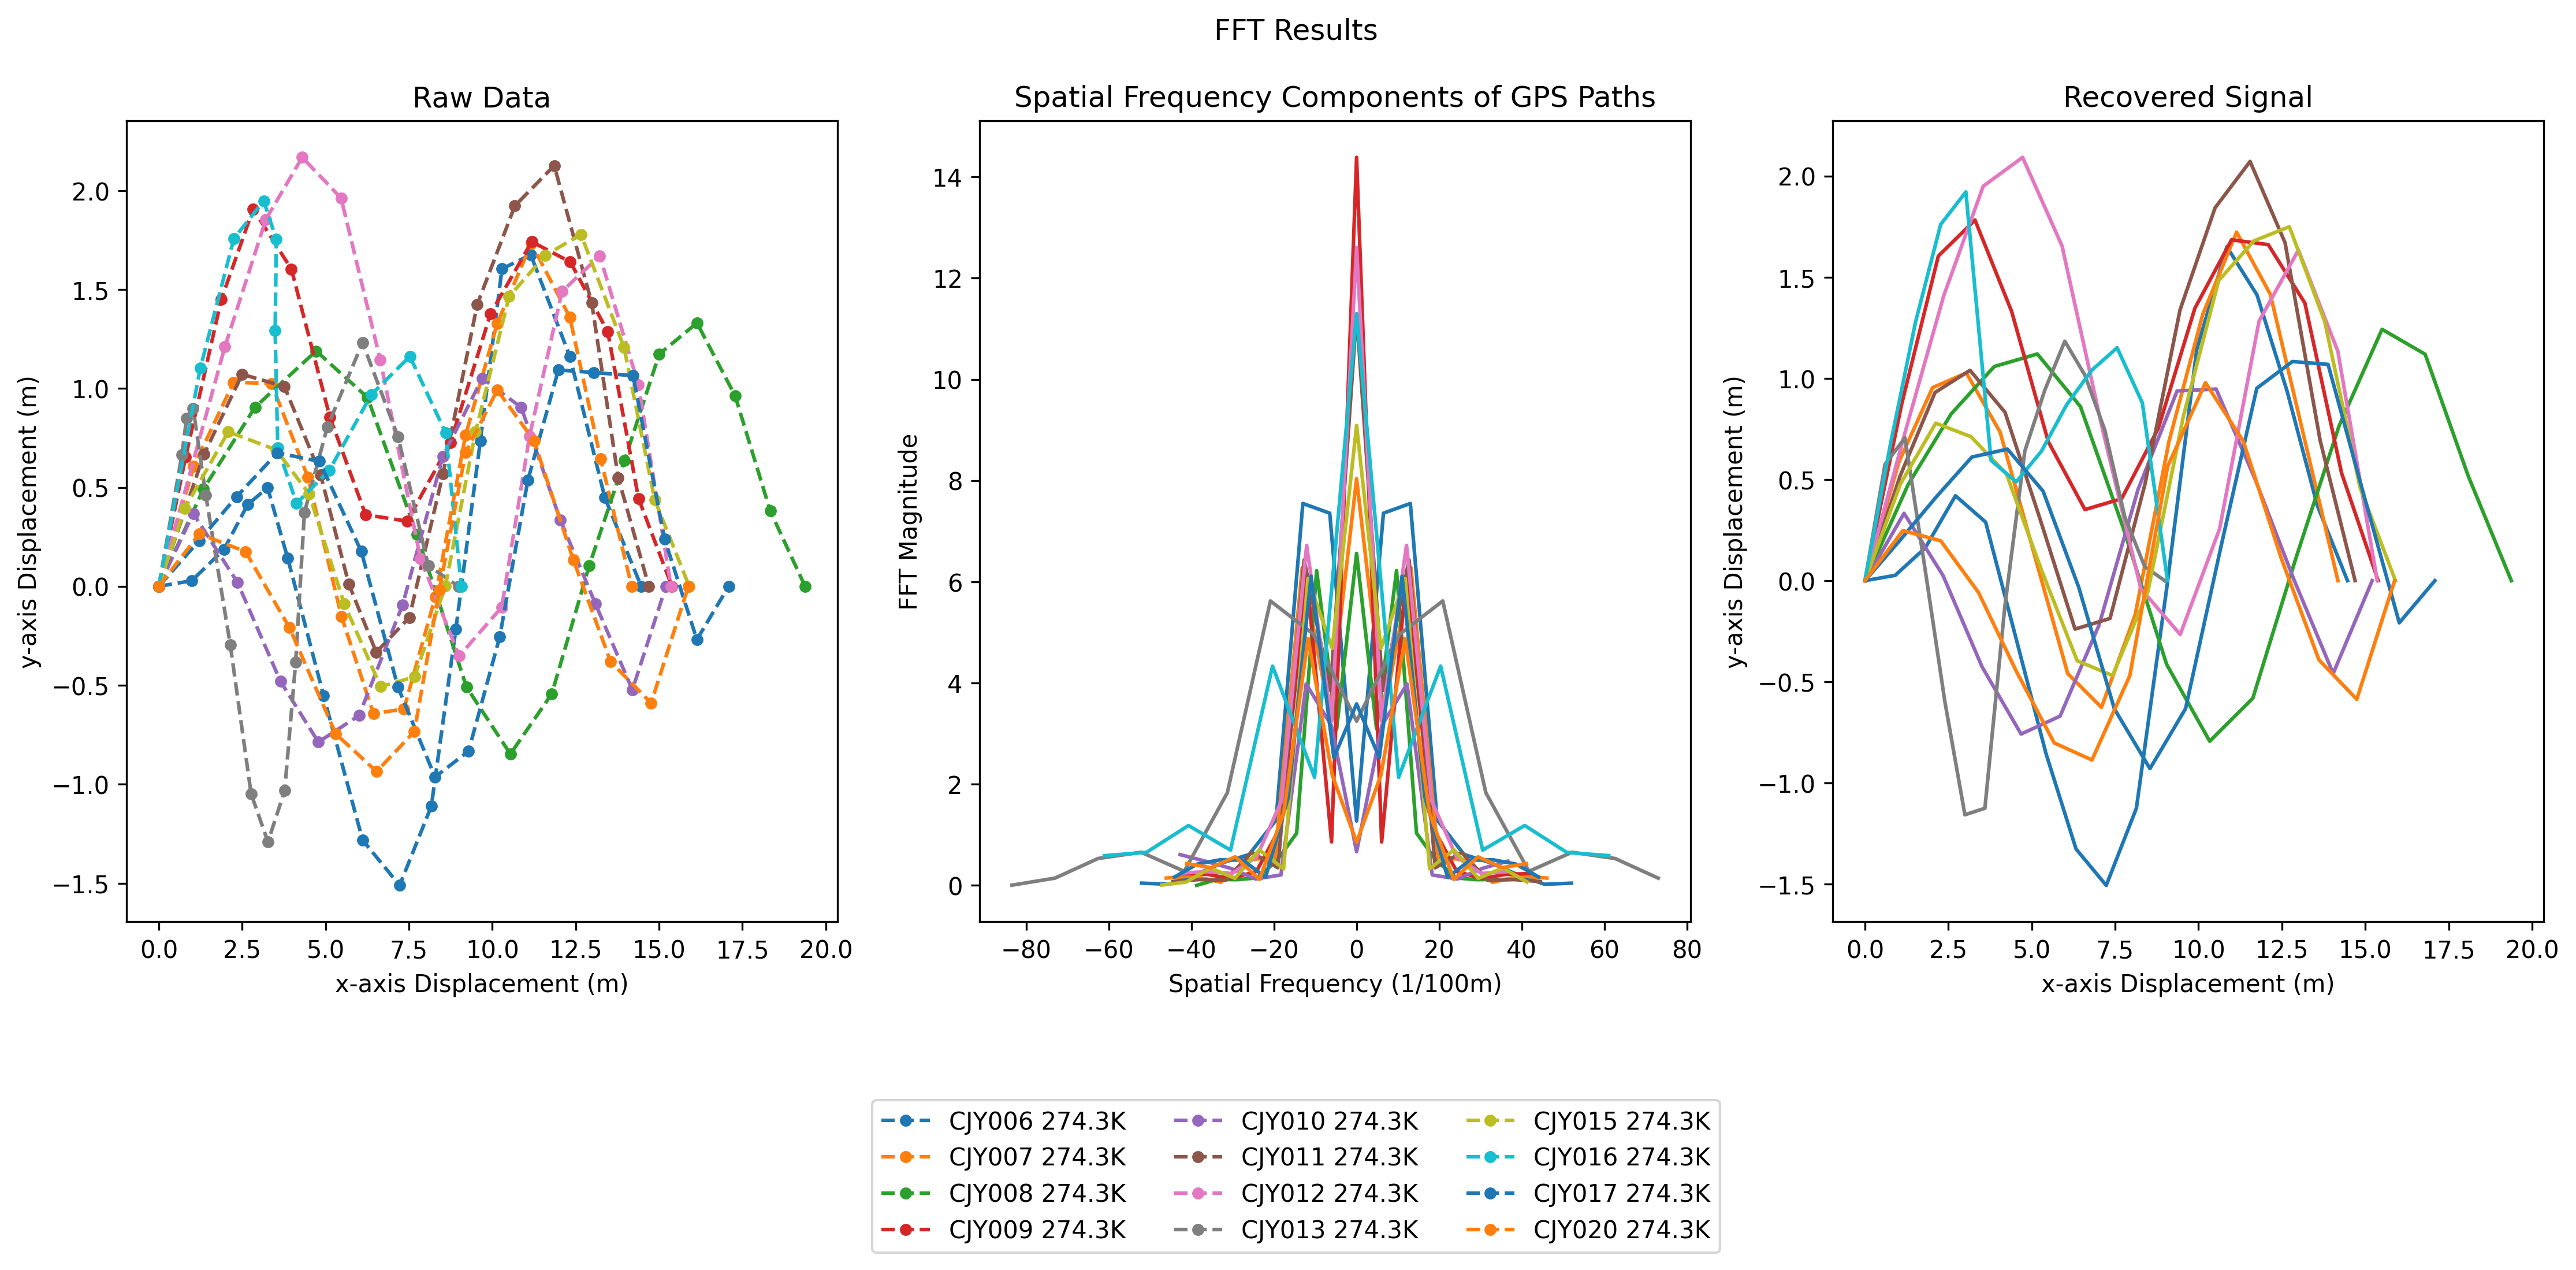

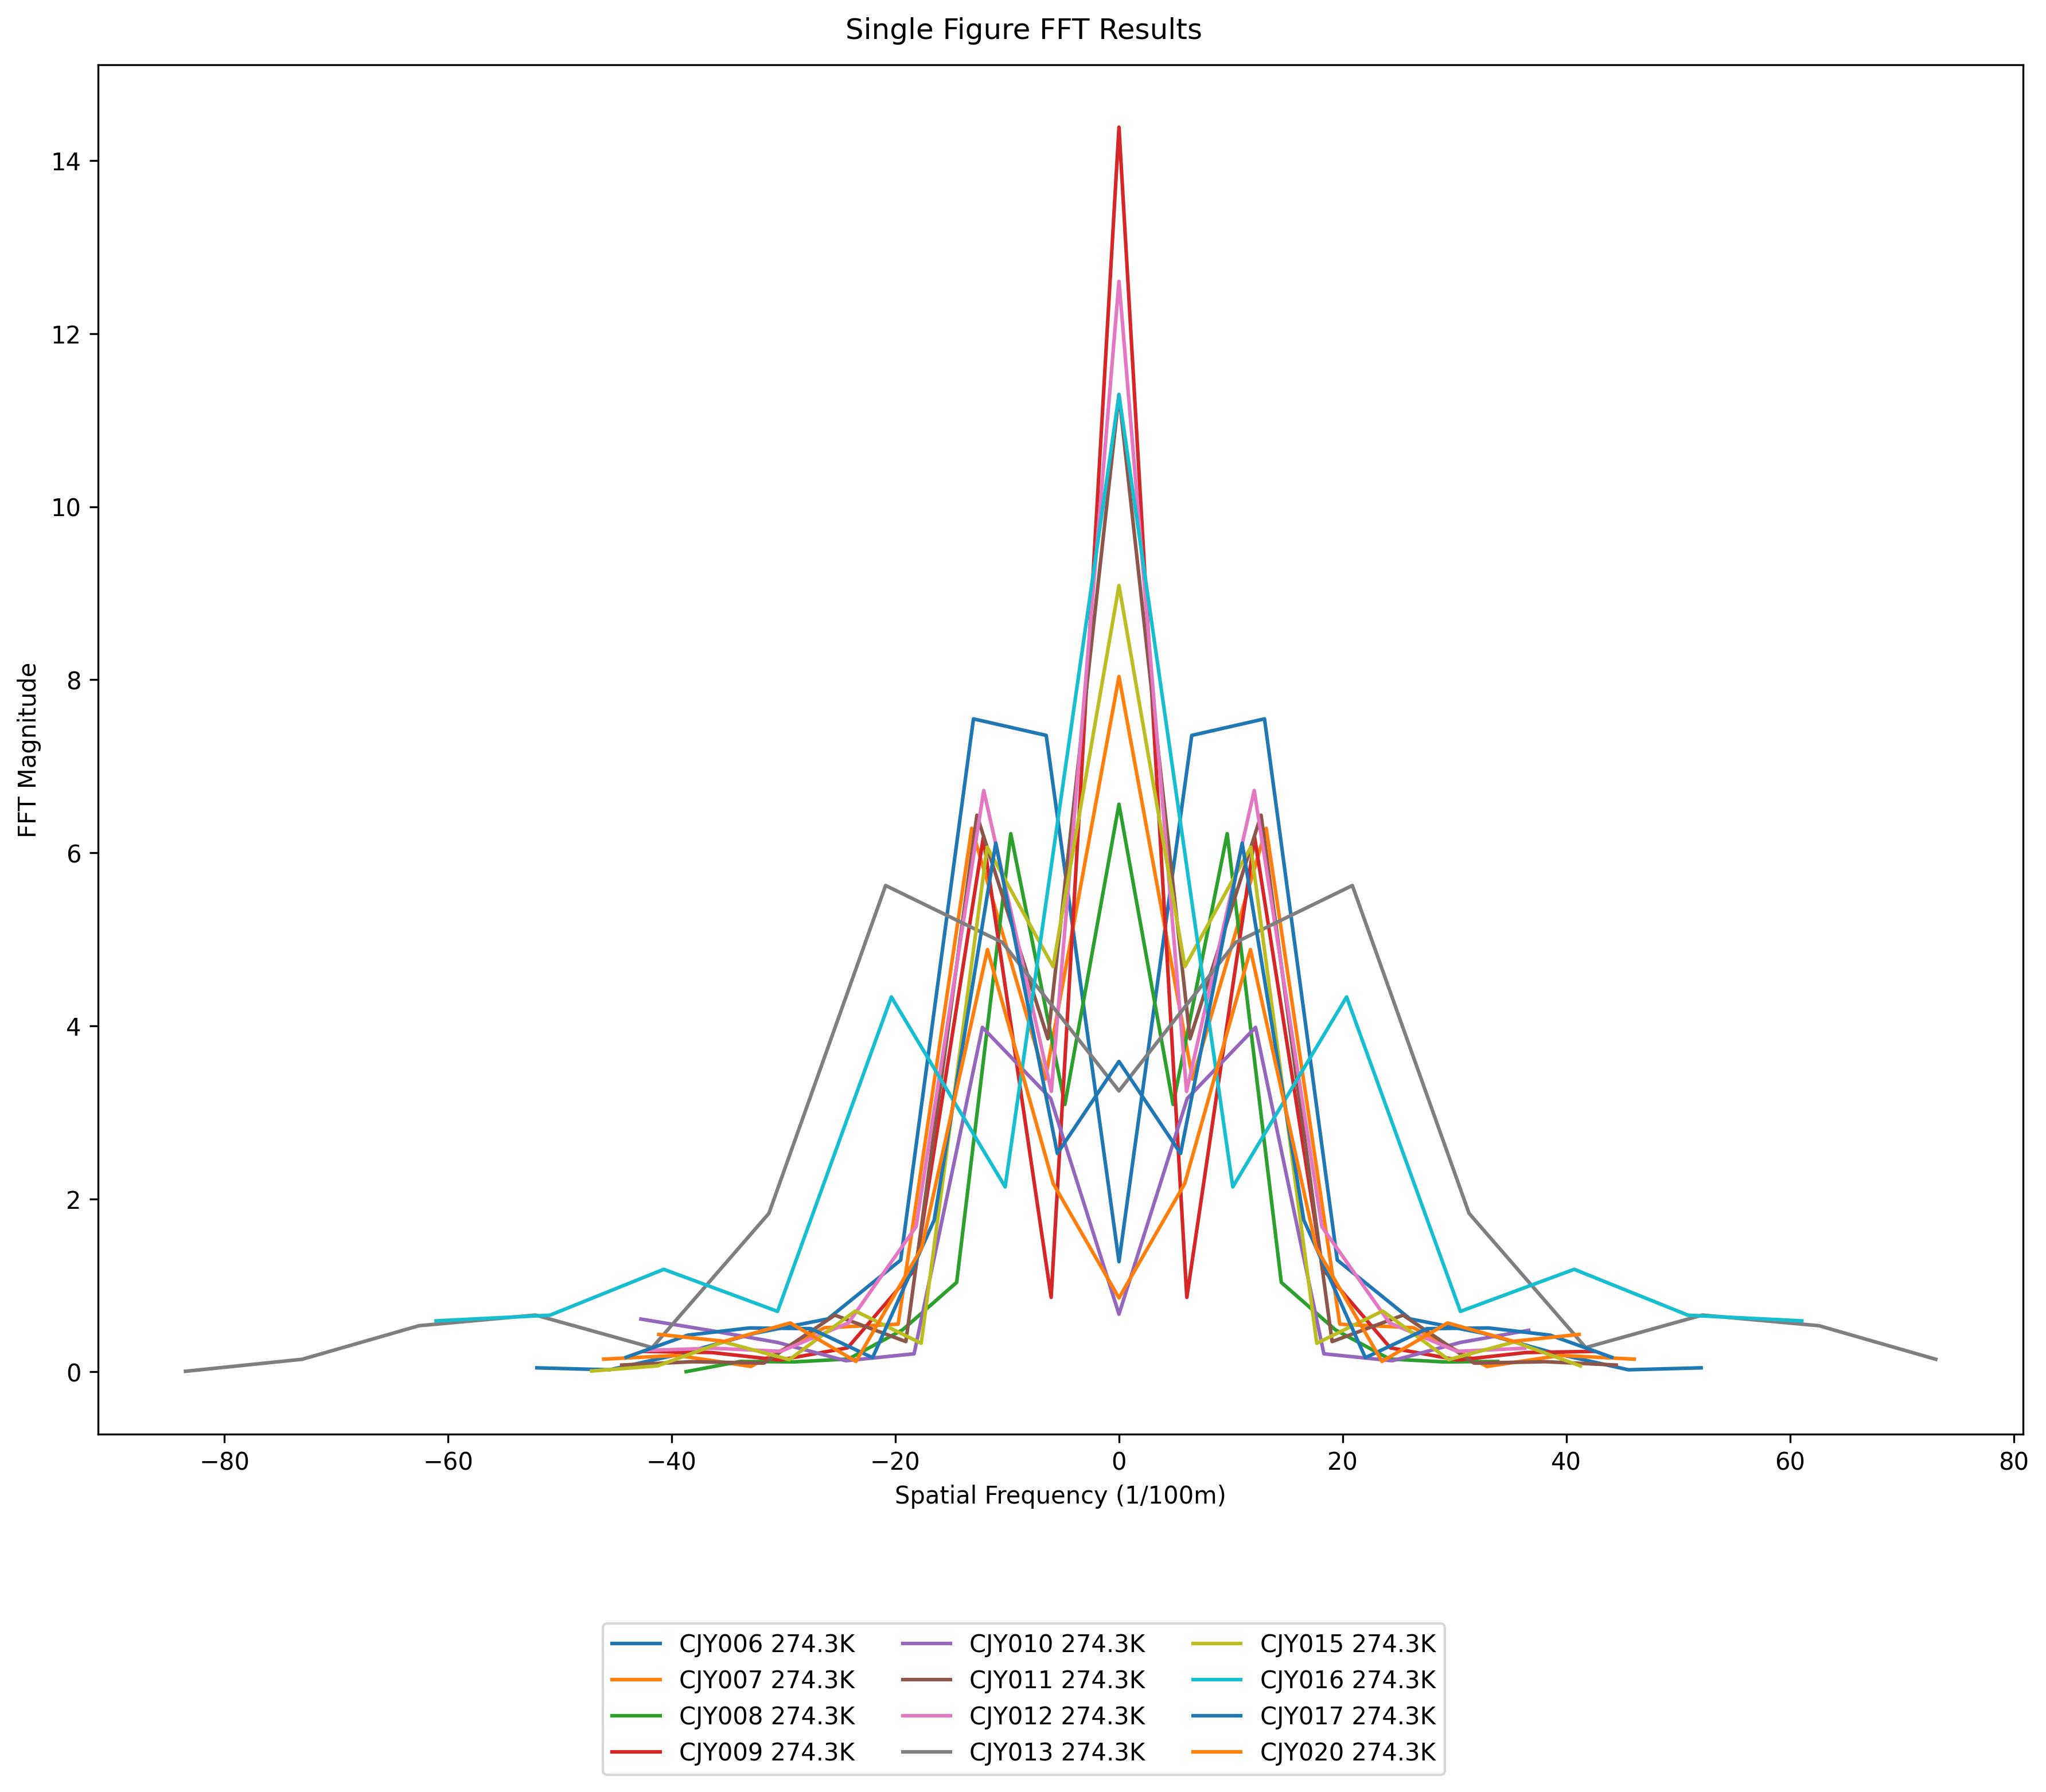

In [70]:
# Get all sinewalk markdown files
md_files = f.list_markdown_files('/workspaces/CP1-24-final/SchrodingersStruggle/data/final', 'sinewalk')

# Set up figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), dpi=300, squeeze=True)
single_fig, single_ax = plt.subplots(1, 1, dpi=300, figsize=(12,9), squeeze=True)

# List to store FFT results
all_ffts = []

# Process each walk
for md_file in md_files:
    # Get unique id (eg. CJY001)
    unique_id = md_file.split('/')[-1].split('_')[0]
    # Same exclusion as before for the same reasons.
    if unique_id in ['CJY001','CJY002','CJY003','CJY004','CJY005','CJY014','CJY018','CJY019']:
        continue
        
    # Get temperature 
    temp_f = f.parse_temperature_from_markdown(md_file)
    temp_k = f.fahrenheit_to_kelvin(temp_f)
    
    # Get corresponding CSV file
    csv_file = md_file.replace('.md', '.csv')
    data = pd.read_csv(csv_file)
    
    # Convert GPS coordinates to meters
    longitudes = data['Longitude (°)'].values[3:-3].tolist()
    latitudes = data['Latitude (°)'].values[3:-3].tolist()
    x, y = gps.convert_xy(longitudes, latitudes)
    x, y = f.rotate_to_horizontal(x, y)
    line = ax1.plot(x, y, 'o--', markersize=4, label=f'{unique_id} {temp_k:.1f}K')
    color = line[0].get_color()
    
    # Create evenly spaced x points for interpolation
    x_uniform = np.linspace(min(x), max(x), len(x))
    y_interp = np.interp(x_uniform, x, y)
    
    # Perform FFT on interpolated data
    freqs, fft_result = f.fft_wrapper(y_interp, x_uniform)
    all_ffts.append(fft_result)
    
    # Convert to spatial frequency in 1/100m
    freqs_100m = freqs * 100
    
    # Plot FFT magnitude
    ax2.plot(freqs_100m, abs(fft_result), '-', color=color)
    single_ax.plot(freqs_100m, abs(fft_result), '-', color=color, label=f'{unique_id} {temp_k:.1f}K')
    
    recovered_signal = f.ifft_wrapper(fft_result)
    ax3.plot(x_uniform, recovered_signal, '-', color=color)

# Plot the 3 subfigures (which looks far more interesting to me).
ax1.set_xlabel('x-axis Displacement (m)')
ax1.set_ylabel('y-axis Displacement (m)')
ax2.set_xlabel('Spatial Frequency (1/100m)')
ax2.set_ylabel('FFT Magnitude')
ax3.set_xlabel('x-axis Displacement (m)')
ax3.set_ylabel('y-axis Displacement (m)')
fig.suptitle('FFT Results')
ax1.set_title('Raw Data')
ax2.set_title('Spatial Frequency Components of GPS Paths')
ax3.set_title('Recovered Signal')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

# Plot the single figure
single_ax.set_xlabel('Spatial Frequency (1/100m)')
single_ax.set_ylabel('FFT Magnitude')
single_fig.suptitle('Single Figure FFT Results')
single_fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.tight_layout()
plt.show()

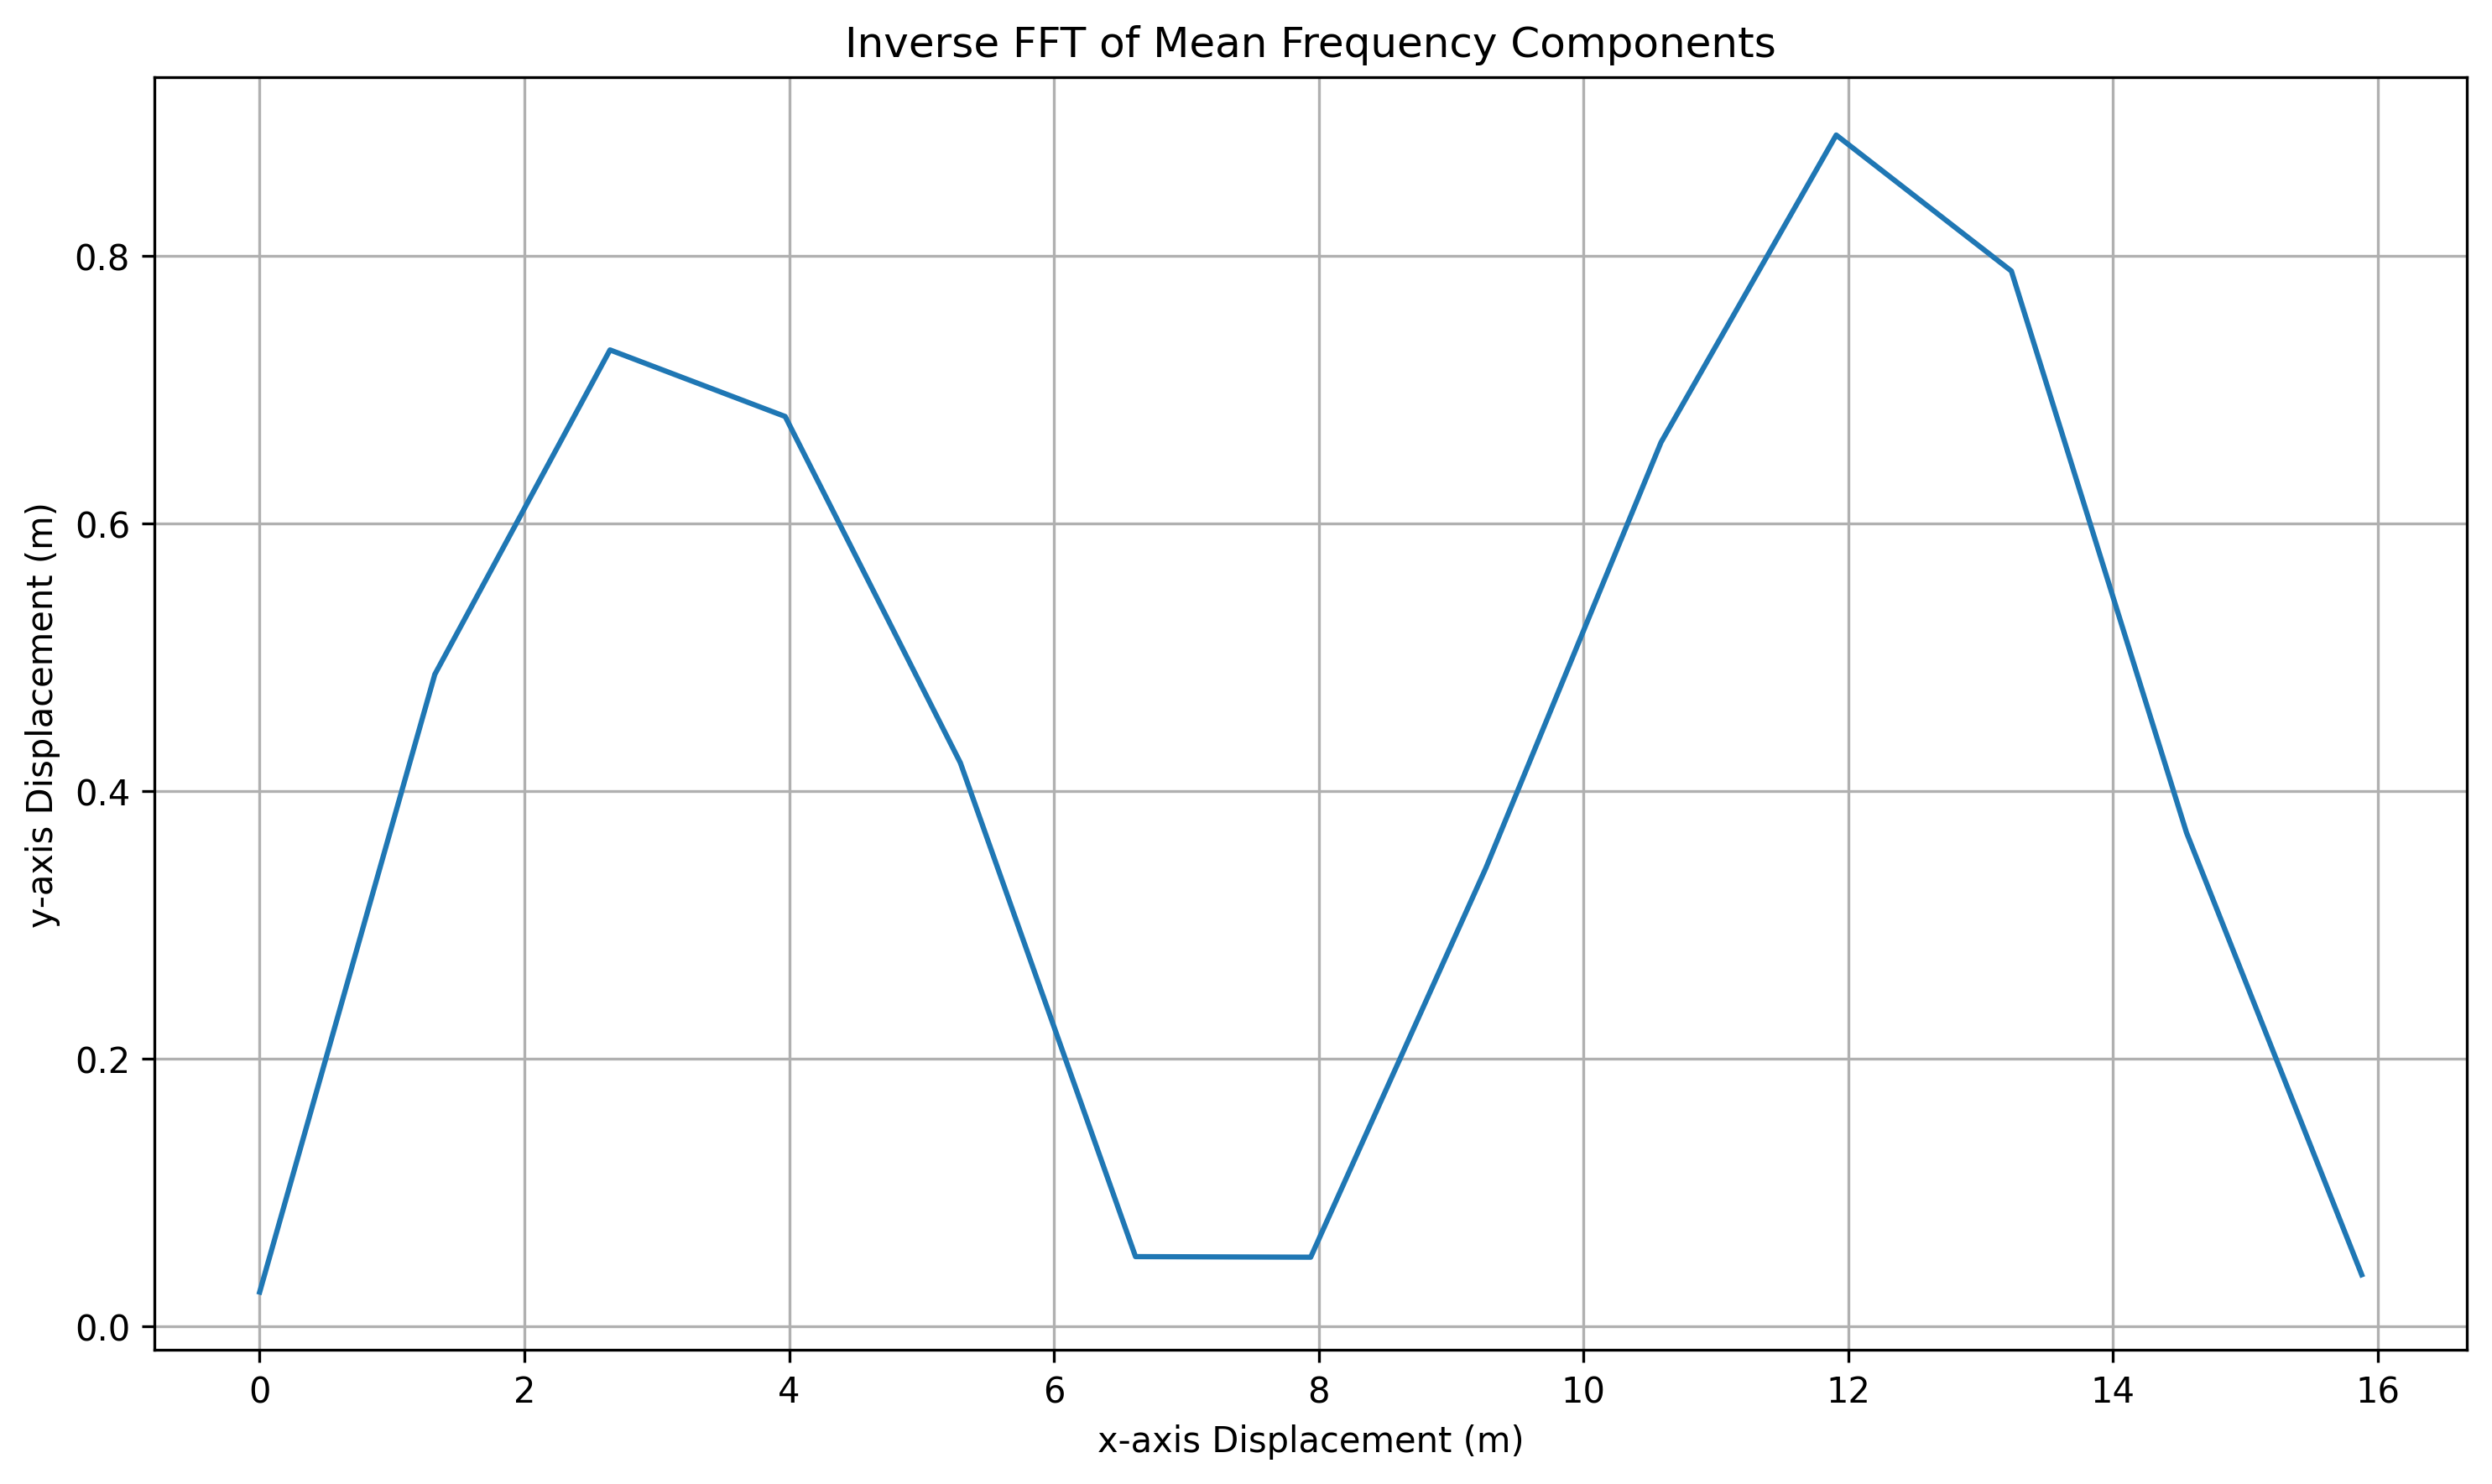

In [73]:
# Convert FFT results to a common length using interpolation
length = min(len(fft) for fft in all_ffts)
interpolated_ffts = [np.interp(np.linspace(0, 1, length), np.linspace(0, 1, len(fft)), fft) for fft in all_ffts]

# Calculate mean FFT across all trials
mean_fft = np.mean(interpolated_ffts, axis=0)

# Get inverse FFT of mean frequency components
recovered_signal = f.ifft_wrapper(mean_fft)

# Match x_uniform's length with recovered_signal
x_uniform= np.linspace(min(x_uniform), max(x_uniform), len(recovered_signal))

# Plot the recovered signal
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(x_uniform, recovered_signal, '-')
plt.xlabel('x-axis Displacement (m)')
plt.ylabel('y-axis Displacement (m)')
plt.title('Inverse FFT of Mean Frequency Components')
plt.grid()
plt.tight_layout()
plt.show()

Today I learned that I'm not very good at walking in a sine pattern, even in the snow.